In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import random

#spectral image library
import spectral as sp

#file management
import os

#keras stuff
from keras.preprocessing.image import ImageDataGenerator
# (resizing is now located in keras.layers.Resizing in newer Keras versions)
from keras.layers.experimental.preprocessing import Resizing, CenterCrop

#sklearn stuff
from sklearn.decomposition import PCA

# Tareas
* Carga de imágenes
* Dataloader?
* Preprocesado de imágenes
* Selección de características?
* Etiquetado de píxeles
* Modelo
* Scores
* Entrenamiento
* Iteración

# Definición de clases y funciones

## Decorators

In [2]:
def exectime(func):
    """Wrapper function which prints the
    execution time of a function
    Args:
        func ([function]): Function to be timed
    """
    def wrapper(*args, **kwargs):
        print(func.__name__)
        start = time.time()
        result = func(*args, **kwargs)
        print("--- %s seconds ---" % (time.time() - start))
        return result
    return wrapper


## Carga de imágenes

### Clase DATAGEN
(Cargado y preprocesado en batches de las imágenes)

In [32]:
class Datagen:
    #PENDIENTE POR AÑADIR:
    # - Etiquetas con las imágenes, para el entrenamiento
    def __init__(self, source_path, filetype, batch_size, shuffle=False):
        self.source_path = source_path
        self.filetype = filetype
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.index = 0
        self.index_order = []
        self.file_list = []
        self.file_list_len = 0
        self.iterable_initiated = False
        
        self._iterable_init()
        
        print(self.index, self.index_order, self.file_list, self.file_list_len, self.iterable_initiated)
        
        
    # Searches all files of type 'filetype' inside the source 'source_path'
    def _file_list(self):
        file_ls = []
        for path, names, files in os.walk(self.source_path, topdown=True):
            # if there are files inside the folder
            if files is not []:
                # add all the files that belong to the defined filetype to the list
                for f in files:
                    if f.endswith(self.filetype):
                        #remove file extension
                        f = f[:-4]
                        file_ls.append(f"{path}/{f}")
        len_file_ls = len(file_ls)
        return file_ls, len_file_ls

    # Carga una imagen hiperespectral completa
    def _image_load(self, image_path):
        path_metadata = path + '.hdr'
        path_image = path + '.bsq'
        img_file = sp.io.envi.open(path_metadata, path_image)
        bands = img_file.read_bands(np.concatenate([range(28), range(36, 62)]))
        return img_file, bands
    
    # Carga únicamente los metadatos de la imagen
    def _metadata_load(self, image_path):
        path_metadata = path + '.hdr'
        path_image = path + '.bsq'
        metadata = sp.io.envi.open(path_metadata, path_image)
        return metadata
    
    # RECORTE DE UNA IMÁGEN EN TORNO AL CENTRO PARA QUE TODAS TENGAN UN MISMO TAMAÑO
    # El formato de entrada de las imágenes ha de ser:
    # (width, height, channels)
    def _crop_images(self, images, width=600, height=600):
        crop = CenterCrop(height=height, width=width)
        cropped = crop(images.reshape(1, images.shape[0], images.shape[1], images.shape[2]))
        cropped = tf.reshape(cropped, [cropped.shape[1], cropped.shape[2], cropped.shape[3]])
        return cropped
    
    # Carga un conjunto de imágenes, les aplica el CROP y las transforma en un único
    def _image_load_set(self, entries):
        paths = self.file_list[entries]
        batch = [self._crop_images(image_load(path)[1]) for path in paths]
        batch = np.array(batch)
        return batch
    
    def _shuffle_order(self, index_order):
        if self.shuffle:
            random.shuffle(index_order)
    
    def _iterable_init(self):
        self.file_list = self._file_list()
        self.file_list_len = len(self.file_list)
        self.index_order = list(range(self.file_list_len))
        self._shuffle_order(self.index_order)
        #if self.shuffle:
        #    random.shuffle(self.index_order)
        self.iterable_initiated = True
            
    def next(self):
        if self.iterable_initiated == False:
            raise Exception("Iterable has not been initiated")
        # si hay suficientes imágenes restantes como para rellenar el batch:
        if self.index + self.batch_size < self.file_list_len:
            next_batch_index = self.index_order[self.index:self.index_order+self.batch_size]
            self.index += self.batch_size
        # si no hay suficientes imágenes como para rellenar el batch: acabar las que quedan,
        # volver a rellenar el vector y acabar de llenar con las nuevas
        else:
            next_batch_index = self.index_order[self.index:]
            remaining_items = self.batch_size - (self.file_list_len - self.index)
            next_batch_index.append(self.index_order[:remaining_items])
            self.index = remaining_items
            
        next_batch = self._image_load(self.index_order(next_batch_index))
        return next_batch

### Funciones realcionadas con filenames

In [5]:
# Searches all files of type 'filetype' inside the source 'source_path'
def file_list(source_path, filetype):
    file_ls = []
    for path, names, files in os.walk(source_path, topdown=True):
        # if there are files inside the folder
        if files is not []:
            # add all the files that belong to the defined filetype to the list
            for f in files:
                if f.endswith(filetype):
                    #remove file extension
                    f = f[:-4]
                    file_ls.append(f"{path}/{f}")
    return file_ls

### Funciones relacionadas con carga de imágenes espectrales

In [4]:
# Carga una imágen hiperespctral completa
@exectime
def image_load(path):
    path_metadata = path + '.hdr'
    path_image = path + '.bsq'
    img_file = sp.io.envi.open(path_metadata, path_image)
    bands = img_file.read_bands(np.concatenate([range(28), range(36, 62)]))
    return img_file, bands

# Carga únicamente los metadatos de la imagen
def metadata_load(path):
    path_metadata = path + '.hdr'
    path_image = path + '.bsq'
    metadata = sp.io.envi.open(path_metadata, path_image)
    return metadata

In [ ]:
def datagen_test(directory):
datagen = ImageDataGenerator()
data_generator = datagen.flow_from_directory(
    directory = directory,
    target_size = 
)

In [ ]:
class DataGenerator:
    def __init__(self):
        
    def set_up_data_flow:
        

### Funciones relacionadas con el preprocesado de las imágenes hiperespectrales

In [18]:
a = list(range(5))
random.shuffle(a)
print(a)

[1, 0, 4, 2, 3]


In [5]:
# RECORTE DE LAS IMÁGENES EN TORNO AL CENTRO PARA QUE TODAS TENGAN UN MISMO TAMAÑO
# El formato de entrada de las imágenes ha de ser uno de los siguientes:
# (width, height, channels) o (batch, width, height, channels)
# El segundo caso sirve para cropear un conjunto de imágenes
def crop_images(images, width=600, height=600):
    crop = CenterCrop(height=height, width=width)
    if np.ndim(images) == 3:
        cropped = crop(images.reshape(1, images.shape[0], images.shape[1], images.shape[2]))
        cropped = tf.reshape(cropped, [cropped.shape[1], cropped.shape[2], cropped.shape[3]])
    elif np.ndim(images) == 4:
        cropped = tf.reshape(images, [images.shape[1], images.shape[2], images.shape[3]])
    else:
        raise Exception("Input image has no correct dimensions")
    return cropped

In [6]:
# ANÁLISIS DE COMPONENTES PRINCIPALES
# Realiza una transformación lineal (rotación de ejes de variables independientes)
# para reducir la variabilidad descrita por las variables al mínimo número de
# variables posible
# La entrada ha de tener la forma [batch, [image size and channels]]
# IMPORTANTE: Muy sensible a outliers
@exectime
def pca(images, n_components=10):
    pca = PCA(n_components=n_components)
    dims = np.prod(images.shape[1:])
    new_images = np.reshape(images, [images.shape[0], dims])
    new_images = pca.fit_transform(new_images)
    print(f"Explained variance ratio \n{pca.explained_variance_ratio_}")
    print(f"Singular values \n{pca.singular_values_}")
    return new_images
# Nota: Es probable que no funcione muy bien porque no todos los píxeles de todas las frutas
# coinciden entre ellos. Sin embargo, merece la pena probar

# TRANSFORMADA WAVELETTES 3D
# Ayuda a quitar ruido, suavizar y comprimir los datos

### Preprocesado

In [30]:
a = [0, 1, 2, 3, 4]
a[0:1]

[0]

In [28]:
datagen = Datagen('dai7', 'bsq', 1)

In [29]:
datagen.next()

TypeError: can only concatenate list (not "int") to list

In [8]:
file_list('dai7', 'bsq')[10]

'dai7/kni/kni_d7_25VISNIR_red_cal'

In [7]:
images = [crop_images(image_load(path)[1]) for path in file_list('dai7', 'bsq')]

image_load
--- 1.466188669204712 seconds ---
image_load
--- 1.4841582775115967 seconds ---
image_load
--- 1.37357497215271 seconds ---
image_load
--- 1.1180968284606934 seconds ---
image_load
--- 1.1952316761016846 seconds ---
image_load
--- 1.3204915523529053 seconds ---
image_load
--- 1.3455708026885986 seconds ---
image_load
--- 1.2594828605651855 seconds ---
image_load
--- 1.3545818328857422 seconds ---
image_load
--- 1.6171386241912842 seconds ---
image_load
--- 1.1596715450286865 seconds ---
image_load
--- 1.1428437232971191 seconds ---
image_load
--- 1.3323874473571777 seconds ---
image_load
--- 1.642690658569336 seconds ---
image_load
--- 1.3439407348632812 seconds ---
image_load
--- 1.1722431182861328 seconds ---
image_load
--- 1.1572792530059814 seconds ---
image_load
--- 1.3999600410461426 seconds ---
image_load
--- 1.2049720287322998 seconds ---
image_load
--- 1.1251327991485596 seconds ---
image_load
--- 1.096346139907837 seconds ---
image_load
--- 1.130561113357544 second

In [8]:
images = np.array(images)

In [19]:
images.shape

(49, 600, 600, 54)

In [ ]:
images_pca = pca(images)

pca


In [51]:
images.shape

(49, 2)

In [49]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.array([7, 8, 9])
ls = [a, b,c]
ls_array = np.array(ls)
ls_array

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

### Entender el formato en el que se han recibido las imágenes

#### Prueba: Mirar el formato de una única imágen

In [45]:
np.ndim(bands)

3

In [4]:
#images = [image_load(path) for path in file_list('dai7', 'bsq')]
files = file_list('dai7', 'bsq')

In [5]:
img, bands = image_load(files[0])

In [6]:
bands.shape

(728, 843, 54)

In [7]:
np.arange(36,62)

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61])

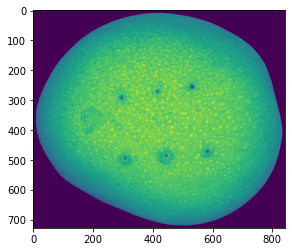

In [8]:
plt.imshow(bands[:,:,52])

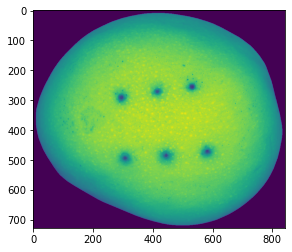

In [9]:
plt.imshow(bands[:,:,42])

#### Prueba: Mirar si todas las imágenes son prácticamente coincidentes en los metadatos

In [10]:
metas = [metadata_load(path) for path in file_list('dai7', 'bsq')]
shapes = [meta.shape for meta in metas]
unique_shapes = set(shapes)

In [11]:
metas[0].shape

(728, 843, 62)

In [12]:
metas[0]

	Data Source:   './dai7/kni/kni_d7_32VISNIR_red_cal.bsq'
	# Rows:            728
	# Samples:         843
	# Bands:            62
	Interleave:        BSQ
	Quantization:  16 bits
	Data format:    uint16

In [13]:
datagen = ImageDataGenerator()

In [33]:
resizer = CenterCrop(height=600, width=600)

In [34]:
resized_image = resizer(bands.reshape(1, bands.shape[0], bands.shape[1], bands.shape[2]))
resized_image = tf.reshape(resized_image, [resized_image.shape[1], resized_image.shape[2], resized_image.shape[3]])
#resized_image = resized_image.reshape(resized_image.shape[1], resized_image.shape[2], resized_image.shape[3])

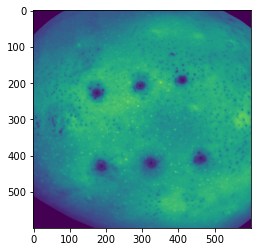

In [35]:
plt.imshow(resized_image[:,:,20])

In [36]:
pca = PCA

In [37]:
new_image

PCA(n_components=<tf.Tensor: shape=(600, 600, 54), dtype=uint16, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0...
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0,

In [43]:
if (new_image.values == resized_image):
    print(True)
else:
    print(False)

AttributeError: 'PCA' object has no attribute 'values'